In [27]:
import requests, zipfile, io
from datetime import datetime
import os
from bs4 import BeautifulSoup as bs # download data
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy import stats
import math
from tqdm import tqdm
import pickle # save pretrained models
import itertools
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera # make animations with matplotlib
import contextily as ctx # add tiles to maps

## 1. Data gathering

In [28]:
# Counts
url = 'http://tfl.gov.uk/tfl/syndication/feeds/counts.zip?app_id=&app_key='
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

directory = "data/raw/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

z.extractall(path=directory)
print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

In [29]:
# Stations, routes and lines
url = 'https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/CSV'
r = requests.get(url)
soup = bs(r.content, 'lxml')
pre = soup.select('pre')

file_names = ['stations.csv', 'routes.csv', 'lines.csv']

for i, p in enumerate(pre):
    df = pd.DataFrame([x.split(',') for x in p.text.split('\n')])
    df.to_csv(directory + file_names[i])
print(f'Downloading date: {datetime.today().strftime("%d-%m-%Y %H:%M:%S")}')

## 2. Data preparation

In [30]:
# Load counts data
skiprows = [_ for _ in range(0, 6)]
counts = pd.read_csv('data/raw/En17week.csv', skiprows=skiprows)
counts.columns = counts.columns.str.strip()

In [31]:
# Load station coordinates
stations = pd.read_csv('data/raw/stations.csv', header=1)
stations.columns = stations.columns.str.replace(r"[\"]", '')
stations['name'] = stations['name'].str.replace(r"[\"]", '')

In [32]:
# Merge counts with station coordinates
station_counts = pd.merge(counts, stations[['latitude', 'longitude', 'name']], left_on='Station', right_on='name')

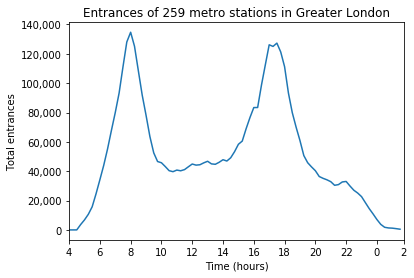

In [39]:
# Visualize total entrances
fig, ax = plt.subplots()
station_counts.loc[:,'0200-0215':'0145-0200'].sum().T.plot(ax=ax)
x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]
ax.set_title(f'Entrances of {station_counts.shape[0]} metro stations in Greater London')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_labels)
ax.set_xlim(9, 96)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total entrances');

In [ ]:
# Transform to GeoDataFrame with working geometry
station_counts = gpd.GeoDataFrame(station_counts, 
                                  geometry=gpd.points_from_xy(station_counts.longitude, station_counts.latitude))

# Asign CRS to make transformations possible 
station_counts.crs = {'init' : 'epsg:4326'}

directory = "data/processed/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
    
station_counts.to_file(directory + 'station_counts.json', driver='GeoJSON')

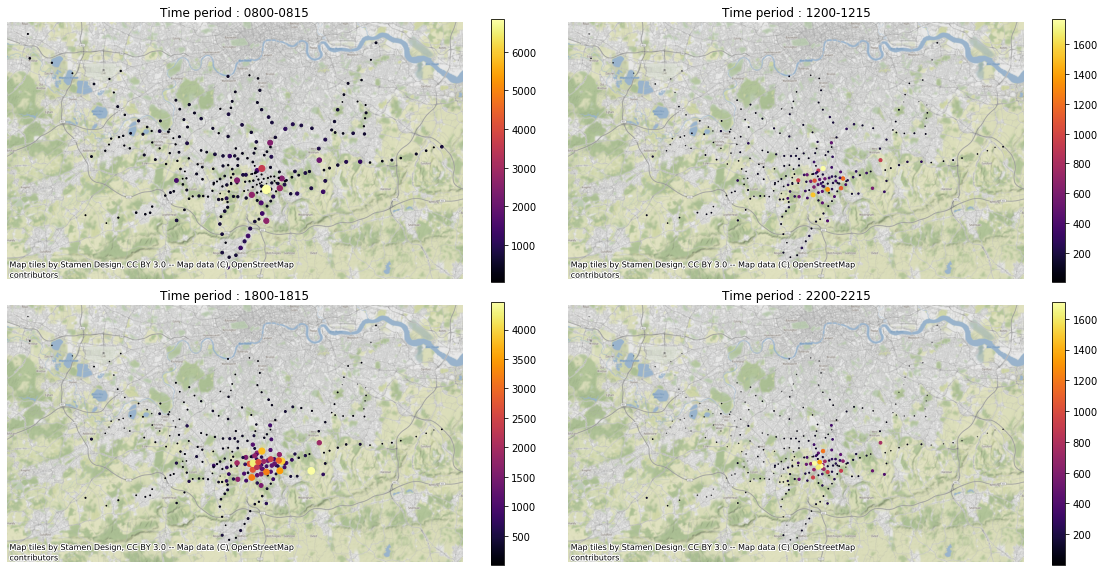

In [41]:
# Visualize entrances at specific time stamps on map
ncols = 2
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,8))
time_stamps = ['0800-0815', '1200-1215', '1800-1815', '2200-2215']
k = 0

for i in range(nrows):
    for j in range(ncols):
        station_timestamp = station_counts.loc[:,[time_stamps[k], 'geometry']]
        station_timestamp['markersize'] = station_timestamp[time_stamps[k]].div(100)
        station_timestamp.to_crs(epsg=3395).plot(ax=ax[i,j], column=time_stamps[k], cmap='inferno', legend=True,
                         markersize='markersize')
        ax[i,j].axis('off')
        ax[i,j].set_title(f'Time period : {time_stamps[k]}')
        ctx.add_basemap(ax=ax[i,j])
        k += 1
fig.tight_layout()
plt.savefig('traffic_map.png', dpi=300)

In [7]:
# Save station names
station_names = station_counts['Station']

# Select only traffic columns
data = station_counts.loc[:,'0200-0215':'0145-0200'] 

# Sum the traffic over the day for each station
N = np.sum(data.T).values

# Scale data
data = data.div(N, axis=0).values

## 3. Transform station counts into individual counts

In [8]:
np.random.seed(1235)

In [9]:
col = []
mat = []
for i in tqdm(range(data.shape[0])):
    rate = N[i]
    jj = np.random.poisson(rate, 1)
    j = jj[0]
    if (j < 1):
        j = 1
    for j in range(j):
        vec = np.random.multinomial(1, data[i,:], size=1)
        col.append(i)
        mat.append(vec[0])

100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [01:12<00:00,  3.55it/s]


In [10]:
# Resulting list of individual entrances
X = np.array(mat)

# Number of time stamps
t = np.arange(0, 96)

# Resulting matrix
Z = np.matmul(X, t)

# Resulting DataFrame
indiviudal_counts = pd.DataFrame()
indiviudal_counts["station_id"] = col
indiviudal_counts["time_stamp"] = Z

# Get stations names
indiviudal_counts = pd.merge(indiviudal_counts, station_names, left_on='station_id', right_on=station_names.index)

# Save the data
indiviudal_counts.to_csv('data/processed/indiviudal_counts.csv', index=False)

## 4. Cluster indiviudal counts with Gaussian mixture model

In [11]:
indiviudal_counts = pd.read_csv('data/processed/indiviudal_counts.csv')

In [12]:
print(f'Clustering will be performed on : {indiviudal_counts.shape[0]} points.')
X = indiviudal_counts["time_stamp"].values
X = X.reshape(-1, 1)

Clustering will be performed on : 4436894 points.


In [13]:
%%time
n_components = 7
random_state = 1235
n_init = 50

# Perform clustering
model = GaussianMixture(n_components, covariance_type='full', random_state=random_state, n_init=n_init).fit(X)
# model = GaussianMixture(n_components, covariance_type='full', random_state=random_state, n_init=n_init, verbose=2).fit(X)

# Get the parameters
labels = model.predict(X)
weights = model.weights_
probs = np.around(model.predict_proba(X), 3)
means = model.means_
covariances = model.covariances_

Wall time: 21min 26s


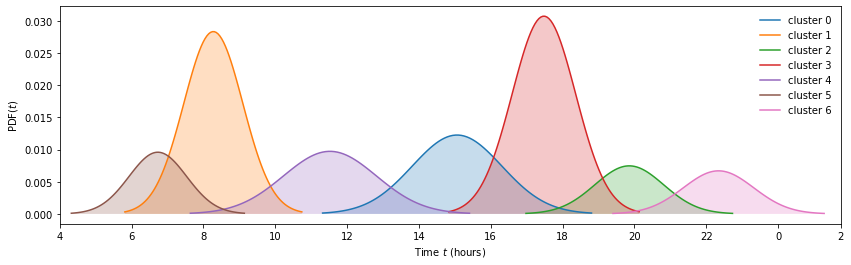

In [14]:
# Plot result of the clustering
sigmas = [math.sqrt(covariance) for covariance in covariances]
counts = pd.DataFrame(labels)[0].value_counts().sort_index()
heights = counts.div(counts.sum())

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]
i = 0
for mean, covariance, sigma, height, label in zip(means, covariances, sigmas, heights, labels):
    x = np.linspace(mean - 3 * sigma, mean + 3 * sigma, 96)
    data = height * stats.norm.pdf(x, mean, sigma)
    ax.plot(x, data, label=f'cluster {i}')
    ax.fill_between(x.ravel(), 0, data.ravel(), alpha=0.25)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks_labels, fontsize=10)
    ax.set_ylabel('PDF($t$)')
    ax.set_xlabel('Time $t$ (hours)')
    i += 1
plt.xlim(left=9, right=96)
plt.legend(frameon=False);

In [15]:
# Save pretrained model and parameters
directory = "model/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

filename = f'model/gmm_{n_components}_components.sav'
pickle.dump(model, open(filename, 'wb')) 
np.save(f"model/labels_{n_components}_components.npy", labels)
np.save(f"model/weights_{n_components}_components.npy", weights)
np.save(f"model/probs_{n_components}_components.npy", probs)
np.save(f"model/means_{n_components}_components.npy", means)
np.save(f"model/covariances_{n_components}_components.npy", covariances)

Succefully created new directory model/


## 4. Generate station counts

In [16]:
# Load the data
station_counts = gpd.read_file('data/processed/station_counts.json')
indiviudal_counts = pd.read_csv(f"data/processed/indiviudal_counts.csv").drop(['station_id', 'time_stamp'], axis=1)

In [17]:
# Load model and parameters
n_components = 7
file_name = f'model/gmm_{n_components}_components.sav'
with open(file_name, 'rb') as f:
    model = pickle.load(f)
labels = np.load(f"model/labels_{n_components}_components.npy", allow_pickle=True)   
probs = np.load(f"model/probs_{n_components}_components.npy", allow_pickle=True)   

In [18]:
# Combine stations with probabilities
df = pd.concat([indiviudal_counts, pd.DataFrame(probs)], axis=1)
# print(df.head())

# Groupby probabilities = cluster labels by station
df = df.groupby('Station').sum()
# print(df.head())

In [19]:
# Get means and std
means = model.means_
covariances = model.covariances_
sigmas = [math.sqrt(covariance) for covariance in covariances]

100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:32<00:00,  7.92it/s]


Wall time: 31min 15s


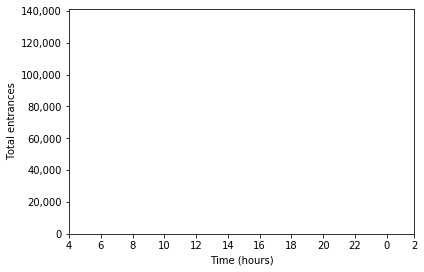

In [20]:
%%time
# Container for sampled stations
sample = []

# 
fig, ax = plt.subplots(figsize=(6,4))
camera = Camera(fig)
x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]
k = 0

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    station = []
    
    # Sample individual entrances at a station 
    # based on their cluster (mean and std)
    for i, j in zip(row, range(0, n_components)):
        station.append(np.random.normal(means[j], sigmas[j], int(i)))
    
    # Flatten the list of lists 
    merged = list(itertools.chain(*station))
    
    # Aggregate individual entries to bins
    n, bins, patches = plt.hist(merged, bins=range(0, 97, 1), color='white', alpha=.0) # exctract n and bins
    sample.append(n)
    
    # Plot origina data
    o = station_counts.loc[:,'0200-0215':'0145-0200'].sum(axis=0).tolist()
    p1= ax.plot(o, color='#0C5DA5')
    plt.legend(p1, [''])
    
    # Plot generated data
    g = pd.DataFrame(sample).sum(axis=0).tolist()
    p2 = ax.plot(g, color='#FF9500') # generated data
    plt.legend(p2, [f'stations generated : {k}'], frameon=False)
    k += 1
    
    # Adjust ticks and labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks_labels)  
    ax.set_xlim(9, 96)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Total entrances')
    ax.text(0.3, 1.01, f'Entrances of {station_counts.shape[0]} stations', transform=ax.transAxes)
    camera.snap()
    
fig.tight_layout()
animation = camera.animate()
animation.save('animation.mp4', dpi=300, fps=10)

In [21]:
# Convert list with sampled stations to a DataFrame
sample = pd.DataFrame(sample)
sample.index = df.index
sample.columns = station_counts.loc[:,'0200-0215':'0145-0200'].columns

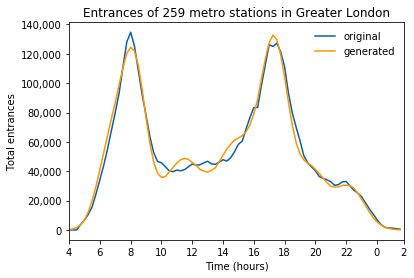

In [22]:
# Static image
fig, ax = plt.subplots(figsize=(6,4))
o = station_counts.loc[:,'0200-0215':'0145-0200'].sum().tolist()
g = sample.sum().tolist()
ax.set_title(f'Entrances of {station_counts.shape[0]} metro stations in Greater London')
ax.plot(o, color='#0C5DA5')
ax.plot(g, color='#FF9500')
ax.legend(['original', 'generated'], frameon=False)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_labels)
ax.set_xlim(9, 96)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total entrances');

In [23]:
station_counts.index = station_counts['Station']

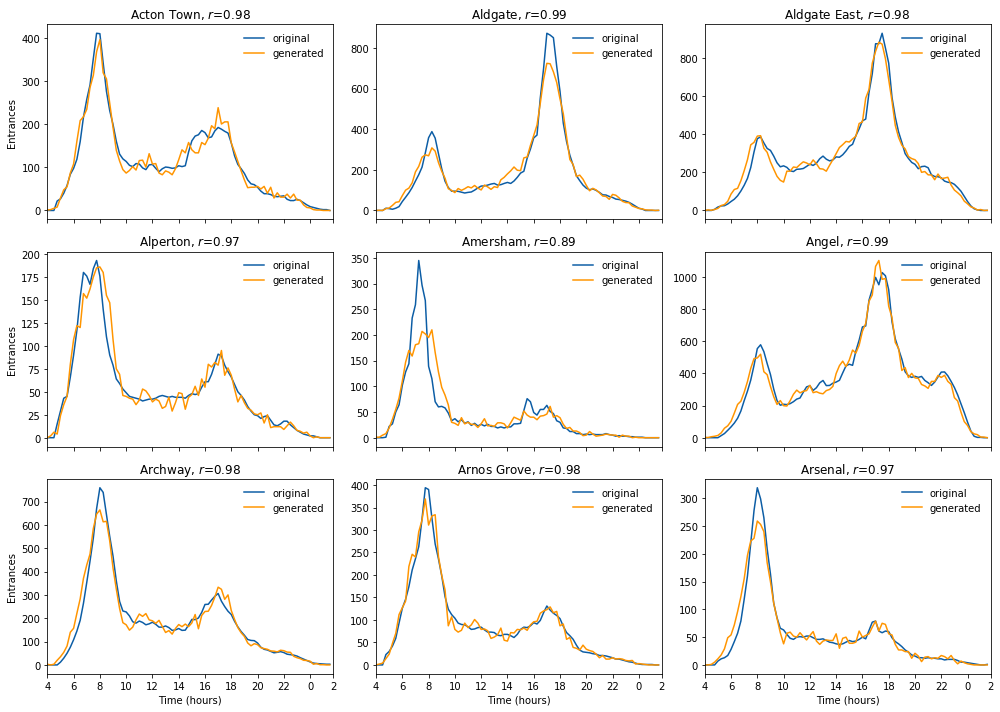

In [24]:
ncols = 3
nrows = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,10), sharex=True)

n = station_counts.shape[0]
l = np.random.randint(low=0, high=n, size=nrows*ncols)
k = 0

x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]

for i in range(nrows):
    for j in range(ncols):
        station_name = station_counts.iloc[k,:]['Station']
        o = station_counts.loc[station_name,'0200-0215':'0145-0200'].tolist()
        g = sample.loc[station_name,:].tolist()
        ax[i, j].plot(o, color='#0C5DA5')
        ax[i, j].plot(g, color='#FF9500')
        r = round(np.corrcoef(o, g)[0, 1], 2)
        ax[i, j].set_title(f'{station_name}, $r$={r}')
        ax[i, j].set_xticks(x_ticks)
        ax[i, j].set_xticklabels(x_ticks_labels)
        ax[i, j].set_xlim(9, 96)
        if j == 0:
            ax[i, j].set_ylabel('Entrances')
        if i == 2:
            ax[i, j].set_xlabel('Time (hours)')
        ax[i, j].legend(['original', 'generated'], frameon=False)
        k += 1
fig.tight_layout()
plt.savefig('sample_stations.png', dpi=300)